In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.sparse import csr_matrix

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
amt_handler = trainer.AmtTrainHandler()
profile_handler = trainer.AmtProfileHandler()
cnt_handler = trainer.CntTrainHandler()

In [3]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
amt_feats = loader.load_result('2021_12_06_amt_feats.joblib')
cnt_feats = loader.load_result('2021_12_15_cnt_feats.joblib')

In [4]:
amt_feats = amt_feats.astype(np.int64)

In [5]:
non_imp_cates = [
    x for x in amt_handler.shop_cate if x not in amt_handler.ylabels
]
amt_drop_feats = []
cnt_drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        amt_cate_col = "shop_{}_amt_{}".format(non_imp_cate, dt - 24)
        cnt_cate_col = "shop_{}_cnt_{}".format(non_imp_cate, dt - 24)
        amt_drop_feats.append(amt_cate_col)
        cnt_drop_feats.append(cnt_cate_col)

In [6]:
cnt_handler.update_data(cnt_feats)
cnt_handler.train = cnt_handler.train.reset_index(drop=True)
cnt_handler.test = cnt_handler.test.reset_index(drop=True)
cnt_handler.train = cnt_handler.train.drop(cnt_drop_feats, axis=1)
cnt_handler.test = cnt_handler.test.drop(cnt_drop_feats, axis=1)

Start Update Data
Start Processing y label
Start Processing train set
Start Processing test set
Finished updating data


In [7]:
cnt_train = cnt_handler.train.copy()
cnt_test = cnt_handler.test.copy()

In [8]:
amt_handler.update_data(amt_feats)
amt_handler.X = amt_handler.X.drop(amt_drop_feats, axis=1)
amt_handler.test = amt_handler.test.drop(amt_drop_feats, axis=1)
amt_test = amt_handler.test.copy()
amt_test['dt'] = 25

amt_train = amt_handler.X.copy()
amt_train['dt'] = [23] * 500000 + [24] * 500000

ylabels = amt_handler.y.copy()

Start Update Data
Finished updating data


In [9]:
amt_train = amt_train.reset_index(drop=True)
amt_test = amt_test.reset_index(drop=True)

profile_handler.update_data(profile_feats)
amt_train = pd.merge(amt_train, profile_feats, on=['chid', 'dt'], how='left')
amt_test = pd.merge(amt_test, profile_feats, on=['chid', 'dt'], how='left')

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [10]:
amt_train = profile_handler.transform(amt_train)
amt_test = profile_handler.transform(amt_test)

In [14]:
import gc 

del amt_feats
del cnt_feats
del profile_feats

gc.collect()

0

In [15]:
cnt_train = cnt_train.drop(['chid'], axis=1)
cnt_test = cnt_test.drop(['chid'], axis=1)

amt_train = amt_train.drop(['chid', 'dt'], axis=1)
amt_test = amt_test.drop(['chid', 'dt'], axis=1)

In [16]:
amt_train = pd.concat([amt_train, cnt_train], axis=1)
amt_test = pd.concat([amt_test, cnt_test], axis=1)

In [17]:
_,_, idx_results = loader.load_result('2021_12_20_amt_train_results.joblib')

In [18]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'regression',
    'metric': 'l2',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [19]:
from sklearn.model_selection import KFold

X = amt_train.copy()
y = ylabels.reset_index(drop=True).copy()

Training fold 1
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.97678e+07	valid_1's l2: 3.06437e+07
[100]	training's l2: 2.69395e+07	valid_1's l2: 2.79238e+07
[150]	training's l2: 2.55766e+07	valid_1's l2: 2.66887e+07
[200]	training's l2: 2.48605e+07	valid_1's l2: 2.61042e+07
[250]	training's l2: 2.44324e+07	valid_1's l2: 2.58143e+07
[300]	training's l2: 2.41431e+07	valid_1's l2: 2.56565e+07
[350]	training's l2: 2.39255e+07	valid_1's l2: 2.55651e+07
[400]	training's l2: 2.37545e+07	valid_1's l2: 2.55104e+07
[450]	training's l2: 2.36156e+07	valid_1's l2: 2.54737e+07
[500]	training's l2: 2.34998e+07	valid_1's l2: 2.54479e+07
[550]	training's l2: 2.3399e+07	valid_1's l2: 2.54303e+07
[600]	training's l2: 2.33152e+07	valid_1's l2: 2.54182e+07
[650]	training's l2: 2.3239e+07	valid_1's l2: 2.54083e+07
[700]	training's l2: 2.3171e+07	valid_1's l2: 2.54019e+07
[750]	training's l2: 2.31056e+07	valid_1's l2: 2.5398e+07
[800]	training's l2: 2.30386e+07	valid_1's

<Figure size 864x432 with 0 Axes>

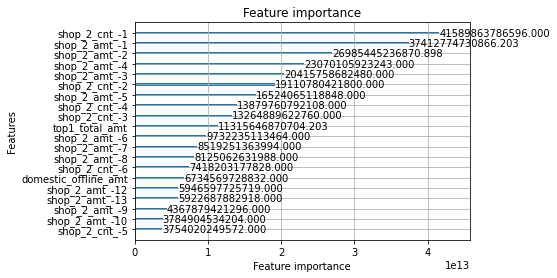

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 6.99777e+06	valid_1's l2: 7.01204e+06
[100]	training's l2: 6.33167e+06	valid_1's l2: 6.36738e+06
[150]	training's l2: 6.01575e+06	valid_1's l2: 6.07354e+06
[200]	training's l2: 5.8616e+06	valid_1's l2: 5.94179e+06
[250]	training's l2: 5.7687e+06	valid_1's l2: 5.87132e+06
[300]	training's l2: 5.71036e+06	valid_1's l2: 5.83493e+06
[350]	training's l2: 5.66834e+06	valid_1's l2: 5.81579e+06
[400]	training's l2: 5.63512e+06	valid_1's l2: 5.80389e+06
[450]	training's l2: 5.6078e+06	valid_1's l2: 5.79675e+06
[500]	training's l2: 5.58332e+06	valid_1's l2: 5.7911e+06
[550]	training's l2: 5.56337e+06	valid_1's l2: 5.78729e+06
[600]	training's l2: 5.54595e+06	valid_1's l2: 5.78451e+06
[650]	training's l2: 5.53087e+06	valid_1's l2: 5.78245e+06
[700]	training's l2: 5.51544e+06	valid_1's l2: 5.78097e+06
[750]	training's l2: 5.50218e+06	valid_1's l2: 5.77976e+06
[800]	training's l2: 5.4878e+06	valid_1's l2: 5.77852e+06


<Figure size 864x432 with 0 Axes>

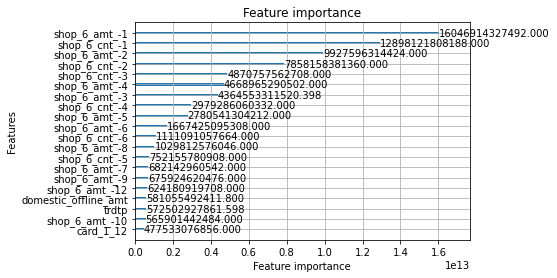

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.3718e+07	valid_1's l2: 2.38224e+07
[100]	training's l2: 2.06883e+07	valid_1's l2: 2.097e+07
[150]	training's l2: 1.9242e+07	valid_1's l2: 1.9683e+07
[200]	training's l2: 1.85055e+07	valid_1's l2: 1.90871e+07
[250]	training's l2: 1.80672e+07	valid_1's l2: 1.8778e+07
[300]	training's l2: 1.77856e+07	valid_1's l2: 1.86192e+07
[350]	training's l2: 1.75808e+07	valid_1's l2: 1.85301e+07
[400]	training's l2: 1.7409e+07	valid_1's l2: 1.8467e+07
[450]	training's l2: 1.72655e+07	valid_1's l2: 1.84227e+07
[500]	training's l2: 1.71427e+07	valid_1's l2: 1.83894e+07
[550]	training's l2: 1.70288e+07	valid_1's l2: 1.83664e+07
[600]	training's l2: 1.69353e+07	valid_1's l2: 1.83493e+07
[650]	training's l2: 1.68502e+07	valid_1's l2: 1.83346e+07
[700]	training's l2: 1.67697e+07	valid_1's l2: 1.83222e+07
[750]	training's l2: 1.66886e+07	valid_1's l2: 1.83101e+07
[800]	training's l2: 1.66241e+07	valid_1's l2: 1.83022e+07
[85

<Figure size 864x432 with 0 Axes>

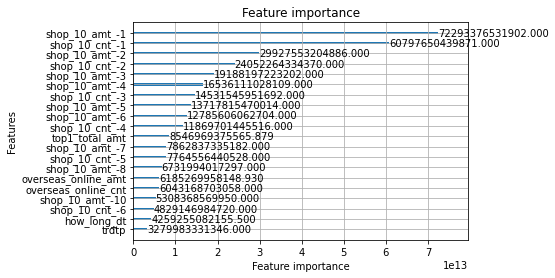

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.56648e+06	valid_1's l2: 9.72357e+06
[100]	training's l2: 8.73381e+06	valid_1's l2: 8.95751e+06
[150]	training's l2: 8.36894e+06	valid_1's l2: 8.65077e+06
[200]	training's l2: 8.16068e+06	valid_1's l2: 8.49067e+06
[250]	training's l2: 8.03983e+06	valid_1's l2: 8.41343e+06
[300]	training's l2: 7.95804e+06	valid_1's l2: 8.37118e+06
[350]	training's l2: 7.89468e+06	valid_1's l2: 8.34608e+06
[400]	training's l2: 7.8438e+06	valid_1's l2: 8.32985e+06
[450]	training's l2: 7.80275e+06	valid_1's l2: 8.32067e+06
[500]	training's l2: 7.76593e+06	valid_1's l2: 8.31368e+06
[550]	training's l2: 7.73227e+06	valid_1's l2: 8.30799e+06
[600]	training's l2: 7.70153e+06	valid_1's l2: 8.30406e+06
[650]	training's l2: 7.6739e+06	valid_1's l2: 8.3006e+06
[700]	training's l2: 7.65154e+06	valid_1's l2: 8.29879e+06
[750]	training's l2: 7.63011e+06	valid_1's l2: 8.29744e+06
[800]	training's l2: 7.60886e+06	valid_1's l2: 8.29632e+0

<Figure size 864x432 with 0 Axes>

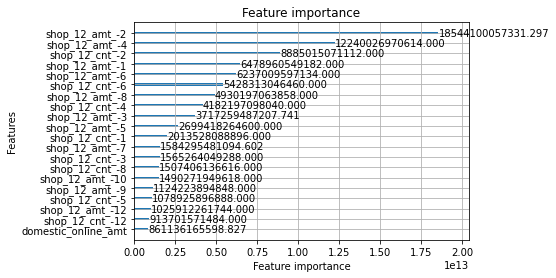

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.46747e+06	valid_1's l2: 3.52191e+06
[100]	training's l2: 2.74694e+06	valid_1's l2: 2.80921e+06
[150]	training's l2: 2.39546e+06	valid_1's l2: 2.46648e+06
[200]	training's l2: 2.22405e+06	valid_1's l2: 2.30559e+06
[250]	training's l2: 2.12615e+06	valid_1's l2: 2.21963e+06
[300]	training's l2: 2.06717e+06	valid_1's l2: 2.17297e+06
[350]	training's l2: 2.01747e+06	valid_1's l2: 2.13572e+06
[400]	training's l2: 1.97498e+06	valid_1's l2: 2.10492e+06
[450]	training's l2: 1.94505e+06	valid_1's l2: 2.0869e+06
[500]	training's l2: 1.91932e+06	valid_1's l2: 2.07276e+06
[550]	training's l2: 1.89725e+06	valid_1's l2: 2.06166e+06
[600]	training's l2: 1.87889e+06	valid_1's l2: 2.05368e+06
[650]	training's l2: 1.86204e+06	valid_1's l2: 2.0466e+06
[700]	training's l2: 1.8452e+06	valid_1's l2: 2.03902e+06
[750]	training's l2: 1.83102e+06	valid_1's l2: 2.03402e+06
[800]	training's l2: 1.81764e+06	valid_1's l2: 2.02969e+0

<Figure size 864x432 with 0 Axes>

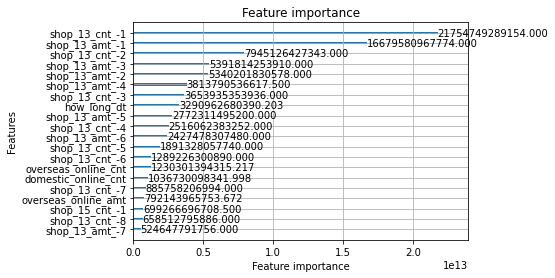

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.81204e+07	valid_1's l2: 1.85189e+07
[100]	training's l2: 1.55835e+07	valid_1's l2: 1.6104e+07
[150]	training's l2: 1.44247e+07	valid_1's l2: 1.50488e+07
[200]	training's l2: 1.38532e+07	valid_1's l2: 1.45733e+07
[250]	training's l2: 1.35363e+07	valid_1's l2: 1.43462e+07
[300]	training's l2: 1.3338e+07	valid_1's l2: 1.42337e+07
[350]	training's l2: 1.31901e+07	valid_1's l2: 1.41653e+07
[400]	training's l2: 1.3076e+07	valid_1's l2: 1.41244e+07
[450]	training's l2: 1.29827e+07	valid_1's l2: 1.40976e+07
[500]	training's l2: 1.29034e+07	valid_1's l2: 1.40768e+07
[550]	training's l2: 1.28371e+07	valid_1's l2: 1.40624e+07
[600]	training's l2: 1.27762e+07	valid_1's l2: 1.40517e+07
[650]	training's l2: 1.27187e+07	valid_1's l2: 1.40421e+07
[700]	training's l2: 1.26726e+07	valid_1's l2: 1.40358e+07
[750]	training's l2: 1.26249e+07	valid_1's l2: 1.40296e+07
[800]	training's l2: 1.2583e+07	valid_1's l2: 1.40249e+07

<Figure size 864x432 with 0 Axes>

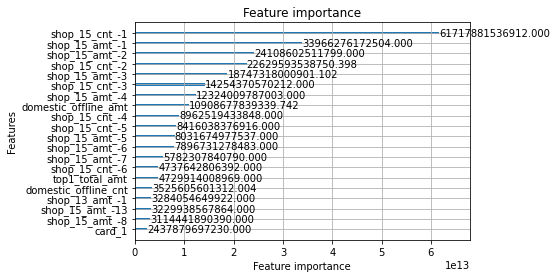

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.824e+06	valid_1's l2: 8.00142e+06
[100]	training's l2: 7.40381e+06	valid_1's l2: 7.62625e+06
[150]	training's l2: 7.18383e+06	valid_1's l2: 7.45051e+06
[200]	training's l2: 7.04779e+06	valid_1's l2: 7.3549e+06
[250]	training's l2: 6.95897e+06	valid_1's l2: 7.30522e+06
[300]	training's l2: 6.89213e+06	valid_1's l2: 7.27422e+06
[350]	training's l2: 6.84087e+06	valid_1's l2: 7.25494e+06
[400]	training's l2: 6.79934e+06	valid_1's l2: 7.24331e+06
[450]	training's l2: 6.76339e+06	valid_1's l2: 7.23514e+06
[500]	training's l2: 6.73279e+06	valid_1's l2: 7.22982e+06
[550]	training's l2: 6.7078e+06	valid_1's l2: 7.22619e+06
[600]	training's l2: 6.68427e+06	valid_1's l2: 7.22306e+06
[650]	training's l2: 6.66066e+06	valid_1's l2: 7.22062e+06
[700]	training's l2: 6.63814e+06	valid_1's l2: 7.21834e+06
[750]	training's l2: 6.61804e+06	valid_1's l2: 7.21698e+06
[800]	training's l2: 6.59815e+06	valid_1's l2: 7.21547e+06

<Figure size 864x432 with 0 Axes>

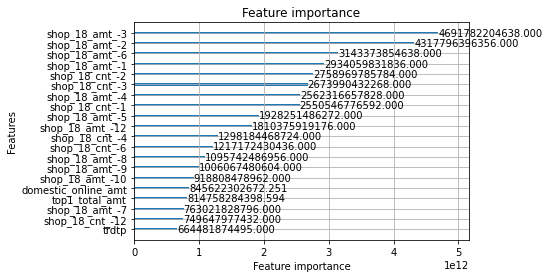

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.43387e+07	valid_1's l2: 1.43216e+07
[100]	training's l2: 1.35587e+07	valid_1's l2: 1.36523e+07
[150]	training's l2: 1.31411e+07	valid_1's l2: 1.33365e+07
[200]	training's l2: 1.28841e+07	valid_1's l2: 1.31737e+07
[250]	training's l2: 1.27135e+07	valid_1's l2: 1.30896e+07
[300]	training's l2: 1.25846e+07	valid_1's l2: 1.304e+07
[350]	training's l2: 1.24835e+07	valid_1's l2: 1.30103e+07
[400]	training's l2: 1.23995e+07	valid_1's l2: 1.29928e+07
[450]	training's l2: 1.23262e+07	valid_1's l2: 1.29811e+07
[500]	training's l2: 1.22686e+07	valid_1's l2: 1.29741e+07
[550]	training's l2: 1.22172e+07	valid_1's l2: 1.2969e+07
[600]	training's l2: 1.2169e+07	valid_1's l2: 1.29639e+07
[650]	training's l2: 1.21291e+07	valid_1's l2: 1.29617e+07
[700]	training's l2: 1.20922e+07	valid_1's l2: 1.296e+07
[750]	training's l2: 1.20559e+07	valid_1's l2: 1.29587e+07
[800]	training's l2: 1.20202e+07	valid_1's l2: 1.29578e+07
[

<Figure size 864x432 with 0 Axes>

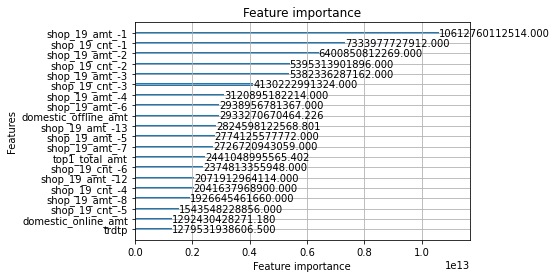

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.37863e+06	valid_1's l2: 8.73162e+06
[100]	training's l2: 8.11935e+06	valid_1's l2: 8.52728e+06
[150]	training's l2: 7.96025e+06	valid_1's l2: 8.41917e+06
[200]	training's l2: 7.85396e+06	valid_1's l2: 8.35857e+06
[250]	training's l2: 7.77709e+06	valid_1's l2: 8.32328e+06
[300]	training's l2: 7.71863e+06	valid_1's l2: 8.30266e+06
[350]	training's l2: 7.67173e+06	valid_1's l2: 8.28969e+06
[400]	training's l2: 7.63153e+06	valid_1's l2: 8.2812e+06
[450]	training's l2: 7.59625e+06	valid_1's l2: 8.27555e+06
[500]	training's l2: 7.56747e+06	valid_1's l2: 8.2718e+06
[550]	training's l2: 7.54041e+06	valid_1's l2: 8.26876e+06
[600]	training's l2: 7.51469e+06	valid_1's l2: 8.26639e+06
[650]	training's l2: 7.49173e+06	valid_1's l2: 8.26524e+06
[700]	training's l2: 7.47029e+06	valid_1's l2: 8.26446e+06
[750]	training's l2: 7.44958e+06	valid_1's l2: 8.26351e+06
[800]	training's l2: 7.42886e+06	valid_1's l2: 8.26282e+

<Figure size 864x432 with 0 Axes>

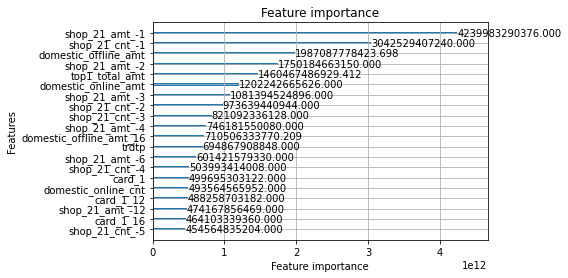

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.56535e+06	valid_1's l2: 2.62741e+06
[100]	training's l2: 2.36245e+06	valid_1's l2: 2.43989e+06
[150]	training's l2: 2.25943e+06	valid_1's l2: 2.35105e+06
[200]	training's l2: 2.20052e+06	valid_1's l2: 2.30606e+06
[250]	training's l2: 2.16526e+06	valid_1's l2: 2.28344e+06
[300]	training's l2: 2.14127e+06	valid_1's l2: 2.27141e+06
[350]	training's l2: 2.12413e+06	valid_1's l2: 2.26498e+06
[400]	training's l2: 2.11042e+06	valid_1's l2: 2.26123e+06
[450]	training's l2: 2.09952e+06	valid_1's l2: 2.25904e+06
[500]	training's l2: 2.09e+06	valid_1's l2: 2.25755e+06
[550]	training's l2: 2.08165e+06	valid_1's l2: 2.25666e+06
[600]	training's l2: 2.07402e+06	valid_1's l2: 2.25618e+06
[650]	training's l2: 2.06689e+06	valid_1's l2: 2.2558e+06
[700]	training's l2: 2.0604e+06	valid_1's l2: 2.25555e+06
[750]	training's l2: 2.05498e+06	valid_1's l2: 2.25543e+06
[800]	training's l2: 2.04981e+06	valid_1's l2: 2.2554e+06
[

<Figure size 864x432 with 0 Axes>

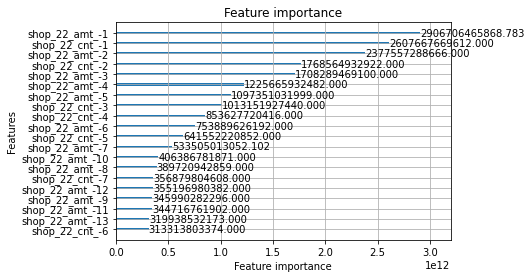

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.15463e+06	valid_1's l2: 4.06588e+06
[100]	training's l2: 3.85125e+06	valid_1's l2: 3.80069e+06
[150]	training's l2: 3.69337e+06	valid_1's l2: 3.67331e+06
[200]	training's l2: 3.60546e+06	valid_1's l2: 3.61207e+06
[250]	training's l2: 3.54911e+06	valid_1's l2: 3.57871e+06
[300]	training's l2: 3.51089e+06	valid_1's l2: 3.56168e+06
[350]	training's l2: 3.48143e+06	valid_1's l2: 3.55146e+06
[400]	training's l2: 3.45844e+06	valid_1's l2: 3.54601e+06
[450]	training's l2: 3.43885e+06	valid_1's l2: 3.5424e+06
[500]	training's l2: 3.42177e+06	valid_1's l2: 3.54e+06
[550]	training's l2: 3.40765e+06	valid_1's l2: 3.53845e+06
[600]	training's l2: 3.39552e+06	valid_1's l2: 3.53738e+06
[650]	training's l2: 3.38503e+06	valid_1's l2: 3.53664e+06
[700]	training's l2: 3.37451e+06	valid_1's l2: 3.53606e+06
[750]	training's l2: 3.36516e+06	valid_1's l2: 3.53549e+06
[800]	training's l2: 3.35489e+06	valid_1's l2: 3.5351e+06


<Figure size 864x432 with 0 Axes>

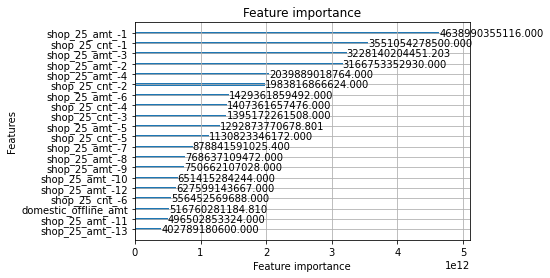

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.1393e+07	valid_1's l2: 1.18831e+07
[100]	training's l2: 1.1009e+07	valid_1's l2: 1.15509e+07
[150]	training's l2: 1.07734e+07	valid_1's l2: 1.1365e+07
[200]	training's l2: 1.06277e+07	valid_1's l2: 1.12656e+07
[250]	training's l2: 1.05269e+07	valid_1's l2: 1.12117e+07
[300]	training's l2: 1.04512e+07	valid_1's l2: 1.11796e+07
[350]	training's l2: 1.03897e+07	valid_1's l2: 1.11592e+07
[400]	training's l2: 1.03413e+07	valid_1's l2: 1.11474e+07
[450]	training's l2: 1.02994e+07	valid_1's l2: 1.11383e+07
[500]	training's l2: 1.02622e+07	valid_1's l2: 1.11318e+07
[550]	training's l2: 1.02308e+07	valid_1's l2: 1.11275e+07
[600]	training's l2: 1.01984e+07	valid_1's l2: 1.11239e+07
[650]	training's l2: 1.01689e+07	valid_1's l2: 1.11207e+07
[700]	training's l2: 1.01402e+07	valid_1's l2: 1.11189e+07
[750]	training's l2: 1.01133e+07	valid_1's l2: 1.11168e+07
[800]	training's l2: 1.00893e+07	valid_1's l2: 1.11161e+0

<Figure size 864x432 with 0 Axes>

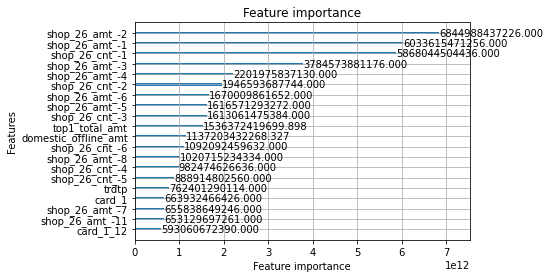

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.36542e+06	valid_1's l2: 8.25925e+06
[100]	training's l2: 6.47132e+06	valid_1's l2: 6.41236e+06
[150]	training's l2: 5.60476e+06	valid_1's l2: 5.58887e+06
[200]	training's l2: 5.20095e+06	valid_1's l2: 5.22493e+06
[250]	training's l2: 4.99952e+06	valid_1's l2: 5.06124e+06
[300]	training's l2: 4.88294e+06	valid_1's l2: 4.98055e+06
[350]	training's l2: 4.79747e+06	valid_1's l2: 4.92918e+06
[400]	training's l2: 4.73685e+06	valid_1's l2: 4.89863e+06
[450]	training's l2: 4.68731e+06	valid_1's l2: 4.87794e+06
[500]	training's l2: 4.6465e+06	valid_1's l2: 4.86435e+06
[550]	training's l2: 4.61091e+06	valid_1's l2: 4.85403e+06
[600]	training's l2: 4.58229e+06	valid_1's l2: 4.84809e+06
[650]	training's l2: 4.55731e+06	valid_1's l2: 4.84367e+06
[700]	training's l2: 4.53238e+06	valid_1's l2: 4.83901e+06
[750]	training's l2: 4.51116e+06	valid_1's l2: 4.83563e+06
[800]	training's l2: 4.49108e+06	valid_1's l2: 4.83301e

<Figure size 864x432 with 0 Axes>

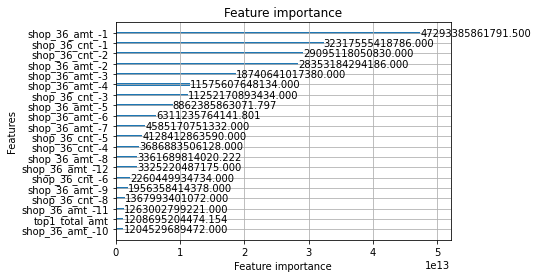

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.46082e+07	valid_1's l2: 2.46643e+07
[100]	training's l2: 2.05653e+07	valid_1's l2: 2.07595e+07
[150]	training's l2: 1.88055e+07	valid_1's l2: 1.91277e+07
[200]	training's l2: 1.79609e+07	valid_1's l2: 1.84034e+07
[250]	training's l2: 1.75078e+07	valid_1's l2: 1.80669e+07
[300]	training's l2: 1.7231e+07	valid_1's l2: 1.78971e+07
[350]	training's l2: 1.70339e+07	valid_1's l2: 1.78019e+07
[400]	training's l2: 1.68846e+07	valid_1's l2: 1.77446e+07
[450]	training's l2: 1.67648e+07	valid_1's l2: 1.77084e+07
[500]	training's l2: 1.66676e+07	valid_1's l2: 1.76852e+07
[550]	training's l2: 1.6578e+07	valid_1's l2: 1.76661e+07
[600]	training's l2: 1.65021e+07	valid_1's l2: 1.76525e+07
[650]	training's l2: 1.64294e+07	valid_1's l2: 1.76411e+07
[700]	training's l2: 1.63613e+07	valid_1's l2: 1.76314e+07
[750]	training's l2: 1.63002e+07	valid_1's l2: 1.76243e+07
[800]	training's l2: 1.62419e+07	valid_1's l2: 1.76189e+

<Figure size 864x432 with 0 Axes>

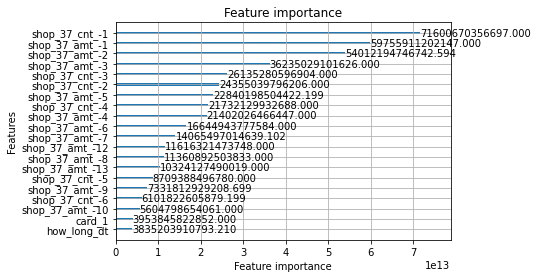

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.04002e+07	valid_1's l2: 1.05821e+07
[100]	training's l2: 9.9735e+06	valid_1's l2: 1.02211e+07
[150]	training's l2: 9.72945e+06	valid_1's l2: 1.00397e+07
[200]	training's l2: 9.57205e+06	valid_1's l2: 9.93995e+06
[250]	training's l2: 9.46358e+06	valid_1's l2: 9.88502e+06
[300]	training's l2: 9.38379e+06	valid_1's l2: 9.85436e+06
[350]	training's l2: 9.32082e+06	valid_1's l2: 9.83375e+06
[400]	training's l2: 9.26983e+06	valid_1's l2: 9.82103e+06
[450]	training's l2: 9.22844e+06	valid_1's l2: 9.8125e+06
[500]	training's l2: 9.19177e+06	valid_1's l2: 9.80687e+06
[550]	training's l2: 9.15795e+06	valid_1's l2: 9.8039e+06
[600]	training's l2: 9.12737e+06	valid_1's l2: 9.80195e+06
[650]	training's l2: 9.09704e+06	valid_1's l2: 9.79976e+06
[700]	training's l2: 9.06887e+06	valid_1's l2: 9.79879e+06
[750]	training's l2: 9.04063e+06	valid_1's l2: 9.79757e+06
[800]	training's l2: 9.01602e+06	valid_1's l2: 9.79726e+0

<Figure size 864x432 with 0 Axes>

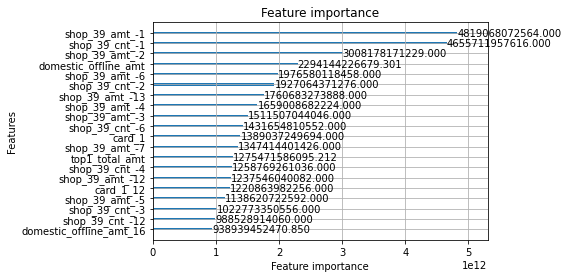

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.13181e+06	valid_1's l2: 9.17228e+06
[100]	training's l2: 7.6756e+06	valid_1's l2: 7.78089e+06
[150]	training's l2: 7.01851e+06	valid_1's l2: 7.17614e+06
[200]	training's l2: 6.68936e+06	valid_1's l2: 6.89385e+06
[250]	training's l2: 6.52051e+06	valid_1's l2: 6.76801e+06
[300]	training's l2: 6.41473e+06	valid_1's l2: 6.70347e+06
[350]	training's l2: 6.34198e+06	valid_1's l2: 6.66962e+06
[400]	training's l2: 6.28365e+06	valid_1's l2: 6.64664e+06
[450]	training's l2: 6.23809e+06	valid_1's l2: 6.63278e+06
[500]	training's l2: 6.19788e+06	valid_1's l2: 6.62275e+06
[550]	training's l2: 6.1613e+06	valid_1's l2: 6.61435e+06
[600]	training's l2: 6.12872e+06	valid_1's l2: 6.60765e+06
[650]	training's l2: 6.1004e+06	valid_1's l2: 6.60297e+06
[700]	training's l2: 6.07296e+06	valid_1's l2: 6.59896e+06
[750]	training's l2: 6.04997e+06	valid_1's l2: 6.59589e+06
[800]	training's l2: 6.02914e+06	valid_1's l2: 6.59351e+0

<Figure size 864x432 with 0 Axes>

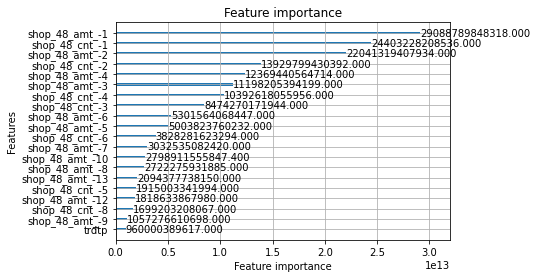

Training fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.0011e+07	valid_1's l2: 3.00673e+07
[100]	training's l2: 2.71733e+07	valid_1's l2: 2.74246e+07
[150]	training's l2: 2.57924e+07	valid_1's l2: 2.62236e+07
[200]	training's l2: 2.50571e+07	valid_1's l2: 2.56585e+07
[250]	training's l2: 2.46197e+07	valid_1's l2: 2.53853e+07
[300]	training's l2: 2.43281e+07	valid_1's l2: 2.52435e+07
[350]	training's l2: 2.41122e+07	valid_1's l2: 2.51637e+07
[400]	training's l2: 2.39437e+07	valid_1's l2: 2.51186e+07
[450]	training's l2: 2.37982e+07	valid_1's l2: 2.50867e+07
[500]	training's l2: 2.36768e+07	valid_1's l2: 2.50654e+07
[550]	training's l2: 2.35757e+07	valid_1's l2: 2.50503e+07
[600]	training's l2: 2.34844e+07	valid_1's l2: 2.50388e+07
[650]	training's l2: 2.34028e+07	valid_1's l2: 2.50316e+07
[700]	training's l2: 2.33355e+07	valid_1's l2: 2.5025e+07
[750]	training's l2: 2.32627e+07	valid_1's l2: 2.50195e+07
[800]	training's l2: 2.31988e+07	valid_1

<Figure size 864x432 with 0 Axes>

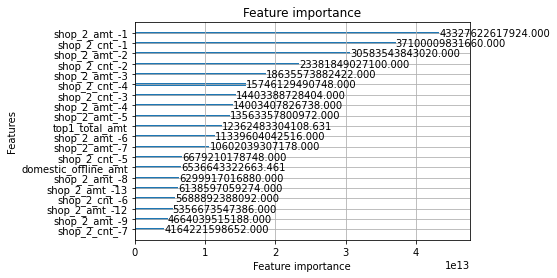

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 6.99351e+06	valid_1's l2: 7.07429e+06
[100]	training's l2: 6.31593e+06	valid_1's l2: 6.41694e+06
[150]	training's l2: 6.00933e+06	valid_1's l2: 6.13471e+06
[200]	training's l2: 5.84978e+06	valid_1's l2: 6.0006e+06
[250]	training's l2: 5.75576e+06	valid_1's l2: 5.93138e+06
[300]	training's l2: 5.69565e+06	valid_1's l2: 5.89599e+06
[350]	training's l2: 5.65009e+06	valid_1's l2: 5.87405e+06
[400]	training's l2: 5.61743e+06	valid_1's l2: 5.86363e+06
[450]	training's l2: 5.58796e+06	valid_1's l2: 5.8557e+06
[500]	training's l2: 5.56065e+06	valid_1's l2: 5.84911e+06
[550]	training's l2: 5.53872e+06	valid_1's l2: 5.84559e+06
[600]	training's l2: 5.51792e+06	valid_1's l2: 5.84276e+06
[650]	training's l2: 5.50026e+06	valid_1's l2: 5.84142e+06
[700]	training's l2: 5.48544e+06	valid_1's l2: 5.84082e+06
[750]	training's l2: 5.47003e+06	valid_1's l2: 5.83986e+06
[800]	training's l2: 5.45551e+06	valid_1's l2: 5.83931e+

<Figure size 864x432 with 0 Axes>

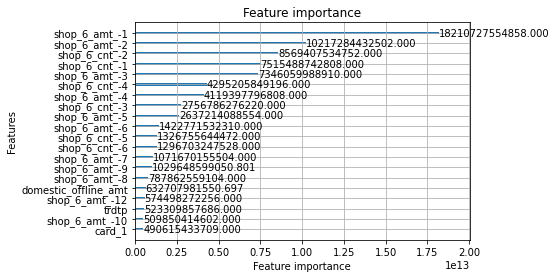

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.36398e+07	valid_1's l2: 2.39665e+07
[100]	training's l2: 2.06889e+07	valid_1's l2: 2.11205e+07
[150]	training's l2: 1.92583e+07	valid_1's l2: 1.98127e+07
[200]	training's l2: 1.85218e+07	valid_1's l2: 1.91968e+07
[250]	training's l2: 1.80859e+07	valid_1's l2: 1.88822e+07
[300]	training's l2: 1.77851e+07	valid_1's l2: 1.86999e+07
[350]	training's l2: 1.75725e+07	valid_1's l2: 1.86e+07
[400]	training's l2: 1.73993e+07	valid_1's l2: 1.85349e+07
[450]	training's l2: 1.72504e+07	valid_1's l2: 1.84872e+07
[500]	training's l2: 1.71243e+07	valid_1's l2: 1.84532e+07
[550]	training's l2: 1.70098e+07	valid_1's l2: 1.84235e+07
[600]	training's l2: 1.69132e+07	valid_1's l2: 1.84051e+07
[650]	training's l2: 1.68247e+07	valid_1's l2: 1.83886e+07
[700]	training's l2: 1.67391e+07	valid_1's l2: 1.83752e+07
[750]	training's l2: 1.66572e+07	valid_1's l2: 1.83638e+07
[800]	training's l2: 1.65922e+07	valid_1's l2: 1.83559e+0

<Figure size 864x432 with 0 Axes>

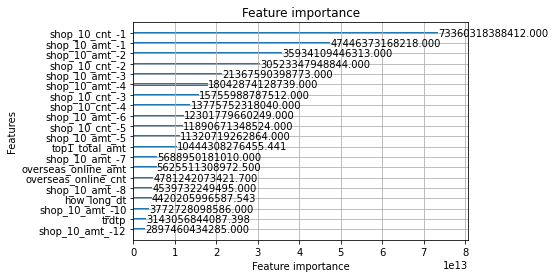

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.53549e+06	valid_1's l2: 9.73531e+06
[100]	training's l2: 8.72238e+06	valid_1's l2: 8.9665e+06
[150]	training's l2: 8.35117e+06	valid_1's l2: 8.64072e+06
[200]	training's l2: 8.1528e+06	valid_1's l2: 8.48703e+06
[250]	training's l2: 8.03508e+06	valid_1's l2: 8.40989e+06
[300]	training's l2: 7.95601e+06	valid_1's l2: 8.36894e+06
[350]	training's l2: 7.89658e+06	valid_1's l2: 8.3451e+06
[400]	training's l2: 7.84792e+06	valid_1's l2: 8.3306e+06
[450]	training's l2: 7.80454e+06	valid_1's l2: 8.3198e+06
[500]	training's l2: 7.76892e+06	valid_1's l2: 8.31306e+06
[550]	training's l2: 7.73611e+06	valid_1's l2: 8.30703e+06
[600]	training's l2: 7.70743e+06	valid_1's l2: 8.30303e+06
[650]	training's l2: 7.68026e+06	valid_1's l2: 8.29983e+06
[700]	training's l2: 7.65536e+06	valid_1's l2: 8.29724e+06
[750]	training's l2: 7.63191e+06	valid_1's l2: 8.29458e+06
[800]	training's l2: 7.61333e+06	valid_1's l2: 8.29362e+06


<Figure size 864x432 with 0 Axes>

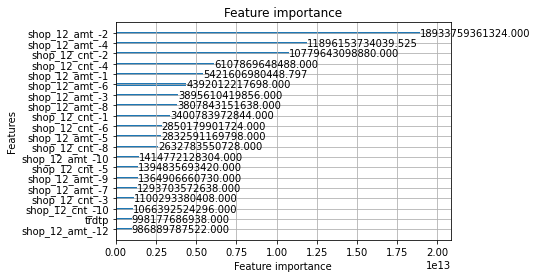

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.43847e+06	valid_1's l2: 3.45911e+06
[100]	training's l2: 2.7478e+06	valid_1's l2: 2.77916e+06
[150]	training's l2: 2.42767e+06	valid_1's l2: 2.47283e+06
[200]	training's l2: 2.24817e+06	valid_1's l2: 2.30773e+06
[250]	training's l2: 2.14394e+06	valid_1's l2: 2.2177e+06
[300]	training's l2: 2.07466e+06	valid_1's l2: 2.16289e+06
[350]	training's l2: 2.02414e+06	valid_1's l2: 2.12613e+06
[400]	training's l2: 1.98856e+06	valid_1's l2: 2.10345e+06
[450]	training's l2: 1.95656e+06	valid_1's l2: 2.08424e+06
[500]	training's l2: 1.92774e+06	valid_1's l2: 2.06758e+06
[550]	training's l2: 1.90805e+06	valid_1's l2: 2.05924e+06
[600]	training's l2: 1.88764e+06	valid_1's l2: 2.04992e+06
[650]	training's l2: 1.86907e+06	valid_1's l2: 2.04215e+06
[700]	training's l2: 1.85189e+06	valid_1's l2: 2.03541e+06
[750]	training's l2: 1.83653e+06	valid_1's l2: 2.02986e+06
[800]	training's l2: 1.82395e+06	valid_1's l2: 2.02649e+

<Figure size 864x432 with 0 Axes>

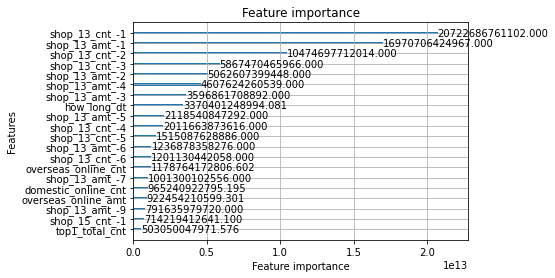

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.8175e+07	valid_1's l2: 1.82749e+07
[100]	training's l2: 1.56906e+07	valid_1's l2: 1.58892e+07
[150]	training's l2: 1.45566e+07	valid_1's l2: 1.48535e+07
[200]	training's l2: 1.39758e+07	valid_1's l2: 1.43706e+07
[250]	training's l2: 1.36485e+07	valid_1's l2: 1.41367e+07
[300]	training's l2: 1.34425e+07	valid_1's l2: 1.40219e+07
[350]	training's l2: 1.32975e+07	valid_1's l2: 1.39594e+07
[400]	training's l2: 1.31833e+07	valid_1's l2: 1.39213e+07
[450]	training's l2: 1.309e+07	valid_1's l2: 1.38951e+07
[500]	training's l2: 1.30065e+07	valid_1's l2: 1.38761e+07
[550]	training's l2: 1.29367e+07	valid_1's l2: 1.38608e+07
[600]	training's l2: 1.28741e+07	valid_1's l2: 1.38502e+07
[650]	training's l2: 1.28241e+07	valid_1's l2: 1.38417e+07
[700]	training's l2: 1.27751e+07	valid_1's l2: 1.38355e+07
[750]	training's l2: 1.27304e+07	valid_1's l2: 1.38301e+07
[800]	training's l2: 1.26919e+07	valid_1's l2: 1.38268e+0

<Figure size 864x432 with 0 Axes>

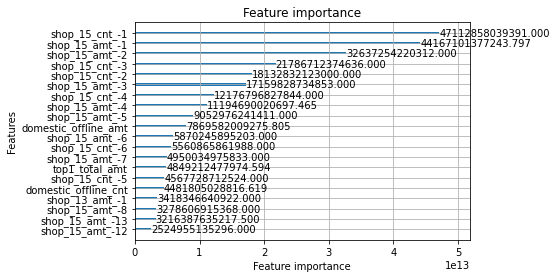

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.8483e+06	valid_1's l2: 7.93198e+06
[100]	training's l2: 7.43941e+06	valid_1's l2: 7.56618e+06
[150]	training's l2: 7.21799e+06	valid_1's l2: 7.3881e+06
[200]	training's l2: 7.0805e+06	valid_1's l2: 7.29218e+06
[250]	training's l2: 6.98918e+06	valid_1's l2: 7.23866e+06
[300]	training's l2: 6.92365e+06	valid_1's l2: 7.20892e+06
[350]	training's l2: 6.87326e+06	valid_1's l2: 7.19091e+06
[400]	training's l2: 6.83245e+06	valid_1's l2: 7.17934e+06
[450]	training's l2: 6.79978e+06	valid_1's l2: 7.17244e+06
[500]	training's l2: 6.76913e+06	valid_1's l2: 7.16671e+06
[550]	training's l2: 6.74326e+06	valid_1's l2: 7.16288e+06
[600]	training's l2: 6.72191e+06	valid_1's l2: 7.16007e+06
[650]	training's l2: 6.70284e+06	valid_1's l2: 7.15828e+06
[700]	training's l2: 6.68309e+06	valid_1's l2: 7.15631e+06
[750]	training's l2: 6.66329e+06	valid_1's l2: 7.15501e+06
[800]	training's l2: 6.64518e+06	valid_1's l2: 7.15422e+0

<Figure size 864x432 with 0 Axes>

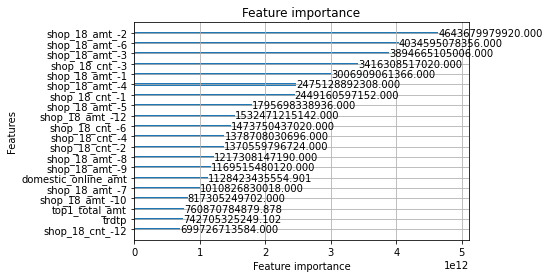

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.43501e+07	valid_1's l2: 1.43342e+07
[100]	training's l2: 1.35676e+07	valid_1's l2: 1.36492e+07
[150]	training's l2: 1.3148e+07	valid_1's l2: 1.33221e+07
[200]	training's l2: 1.28931e+07	valid_1's l2: 1.31583e+07
[250]	training's l2: 1.27216e+07	valid_1's l2: 1.30684e+07
[300]	training's l2: 1.25934e+07	valid_1's l2: 1.30158e+07
[350]	training's l2: 1.2493e+07	valid_1's l2: 1.29824e+07
[400]	training's l2: 1.24111e+07	valid_1's l2: 1.29634e+07
[450]	training's l2: 1.23405e+07	valid_1's l2: 1.29491e+07
[500]	training's l2: 1.22828e+07	valid_1's l2: 1.29396e+07
[550]	training's l2: 1.22317e+07	valid_1's l2: 1.29334e+07
[600]	training's l2: 1.21836e+07	valid_1's l2: 1.29282e+07
[650]	training's l2: 1.21466e+07	valid_1's l2: 1.29254e+07
[700]	training's l2: 1.21093e+07	valid_1's l2: 1.29228e+07
[750]	training's l2: 1.20697e+07	valid_1's l2: 1.29209e+07
[800]	training's l2: 1.20382e+07	valid_1's l2: 1.29198e+

<Figure size 864x432 with 0 Axes>

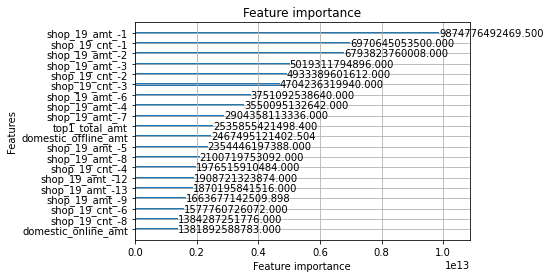

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.54891e+06	valid_1's l2: 8.41408e+06
[100]	training's l2: 8.27446e+06	valid_1's l2: 8.20151e+06
[150]	training's l2: 8.11129e+06	valid_1's l2: 8.09541e+06
[200]	training's l2: 8.0021e+06	valid_1's l2: 8.03849e+06
[250]	training's l2: 7.92217e+06	valid_1's l2: 8.0067e+06
[300]	training's l2: 7.86364e+06	valid_1's l2: 7.98962e+06
[350]	training's l2: 7.81706e+06	valid_1's l2: 7.98001e+06
[400]	training's l2: 7.77648e+06	valid_1's l2: 7.97269e+06
[450]	training's l2: 7.74303e+06	valid_1's l2: 7.96869e+06
[500]	training's l2: 7.71319e+06	valid_1's l2: 7.96562e+06
[550]	training's l2: 7.68544e+06	valid_1's l2: 7.96296e+06
[600]	training's l2: 7.6618e+06	valid_1's l2: 7.96139e+06
[650]	training's l2: 7.63748e+06	valid_1's l2: 7.96053e+06
[700]	training's l2: 7.61407e+06	valid_1's l2: 7.9596e+06
[750]	training's l2: 7.59186e+06	valid_1's l2: 7.95888e+06
[800]	training's l2: 7.57064e+06	valid_1's l2: 7.95898e+06

<Figure size 864x432 with 0 Axes>

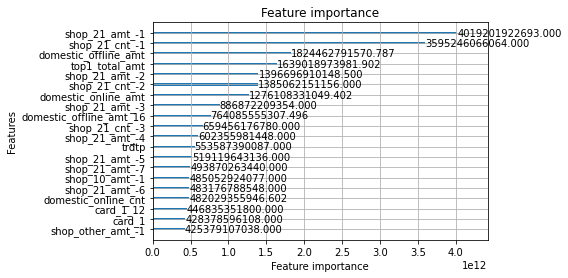

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.58611e+06	valid_1's l2: 2.57351e+06
[100]	training's l2: 2.38589e+06	valid_1's l2: 2.38798e+06
[150]	training's l2: 2.28457e+06	valid_1's l2: 2.29959e+06
[200]	training's l2: 2.22853e+06	valid_1's l2: 2.25524e+06
[250]	training's l2: 2.19458e+06	valid_1's l2: 2.23183e+06
[300]	training's l2: 2.17133e+06	valid_1's l2: 2.21822e+06
[350]	training's l2: 2.15403e+06	valid_1's l2: 2.21041e+06
[400]	training's l2: 2.14033e+06	valid_1's l2: 2.20554e+06
[450]	training's l2: 2.12889e+06	valid_1's l2: 2.20238e+06
[500]	training's l2: 2.11961e+06	valid_1's l2: 2.20034e+06
[550]	training's l2: 2.11096e+06	valid_1's l2: 2.19866e+06
[600]	training's l2: 2.10402e+06	valid_1's l2: 2.19767e+06
[650]	training's l2: 2.09699e+06	valid_1's l2: 2.19679e+06
[700]	training's l2: 2.09088e+06	valid_1's l2: 2.19646e+06
[750]	training's l2: 2.08549e+06	valid_1's l2: 2.1961e+06
[800]	training's l2: 2.08003e+06	valid_1's l2: 2.19577e

<Figure size 864x432 with 0 Axes>

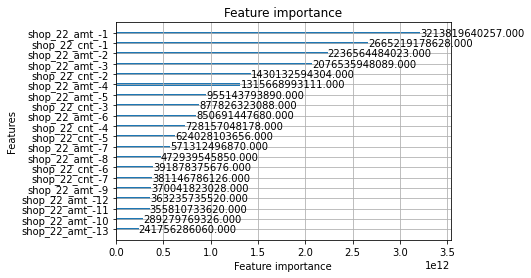

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.11441e+06	valid_1's l2: 4.13574e+06
[100]	training's l2: 3.81888e+06	valid_1's l2: 3.86792e+06
[150]	training's l2: 3.66308e+06	valid_1's l2: 3.73789e+06
[200]	training's l2: 3.57186e+06	valid_1's l2: 3.67088e+06
[250]	training's l2: 3.51657e+06	valid_1's l2: 3.6387e+06
[300]	training's l2: 3.47801e+06	valid_1's l2: 3.62155e+06
[350]	training's l2: 3.44824e+06	valid_1's l2: 3.61225e+06
[400]	training's l2: 3.42564e+06	valid_1's l2: 3.60672e+06
[450]	training's l2: 3.4052e+06	valid_1's l2: 3.60333e+06
[500]	training's l2: 3.38848e+06	valid_1's l2: 3.60122e+06
[550]	training's l2: 3.37436e+06	valid_1's l2: 3.59995e+06
[600]	training's l2: 3.36123e+06	valid_1's l2: 3.599e+06
[650]	training's l2: 3.34925e+06	valid_1's l2: 3.59835e+06
[700]	training's l2: 3.33877e+06	valid_1's l2: 3.59798e+06
[750]	training's l2: 3.32923e+06	valid_1's l2: 3.59774e+06
[800]	training's l2: 3.32089e+06	valid_1's l2: 3.5979e+06


<Figure size 864x432 with 0 Axes>

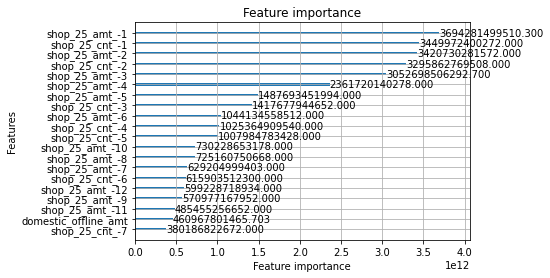

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.15527e+07	valid_1's l2: 1.15498e+07
[100]	training's l2: 1.11596e+07	valid_1's l2: 1.12131e+07
[150]	training's l2: 1.09219e+07	valid_1's l2: 1.10278e+07
[200]	training's l2: 1.07782e+07	valid_1's l2: 1.09334e+07
[250]	training's l2: 1.0679e+07	valid_1's l2: 1.08802e+07
[300]	training's l2: 1.06042e+07	valid_1's l2: 1.08494e+07
[350]	training's l2: 1.05476e+07	valid_1's l2: 1.08326e+07
[400]	training's l2: 1.04973e+07	valid_1's l2: 1.08194e+07
[450]	training's l2: 1.04576e+07	valid_1's l2: 1.0811e+07
[500]	training's l2: 1.04219e+07	valid_1's l2: 1.08051e+07
[550]	training's l2: 1.039e+07	valid_1's l2: 1.08005e+07
[600]	training's l2: 1.0359e+07	valid_1's l2: 1.07971e+07
[650]	training's l2: 1.03315e+07	valid_1's l2: 1.07951e+07
[700]	training's l2: 1.03059e+07	valid_1's l2: 1.07932e+07
[750]	training's l2: 1.02788e+07	valid_1's l2: 1.07913e+07
[800]	training's l2: 1.02551e+07	valid_1's l2: 1.07898e+07


<Figure size 864x432 with 0 Axes>

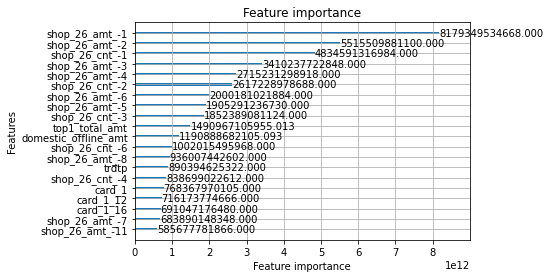

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.26294e+06	valid_1's l2: 8.46413e+06
[100]	training's l2: 6.36209e+06	valid_1's l2: 6.59365e+06
[150]	training's l2: 5.49092e+06	valid_1's l2: 5.75042e+06
[200]	training's l2: 5.09512e+06	valid_1's l2: 5.38358e+06
[250]	training's l2: 4.89289e+06	valid_1's l2: 5.21105e+06
[300]	training's l2: 4.77671e+06	valid_1's l2: 5.1253e+06
[350]	training's l2: 4.69982e+06	valid_1's l2: 5.07772e+06
[400]	training's l2: 4.64491e+06	valid_1's l2: 5.05111e+06
[450]	training's l2: 4.60137e+06	valid_1's l2: 5.03516e+06
[500]	training's l2: 4.565e+06	valid_1's l2: 5.02409e+06
[550]	training's l2: 4.53369e+06	valid_1's l2: 5.01643e+06
[600]	training's l2: 4.50536e+06	valid_1's l2: 5.00993e+06
[650]	training's l2: 4.4808e+06	valid_1's l2: 5.0052e+06
[700]	training's l2: 4.45894e+06	valid_1's l2: 5.00156e+06
[750]	training's l2: 4.43781e+06	valid_1's l2: 4.99861e+06
[800]	training's l2: 4.41888e+06	valid_1's l2: 4.99624e+06


<Figure size 864x432 with 0 Axes>

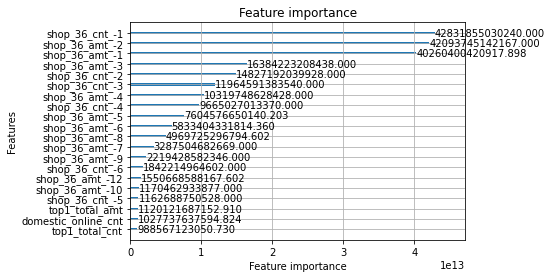

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.45458e+07	valid_1's l2: 2.46698e+07
[100]	training's l2: 2.05667e+07	valid_1's l2: 2.07956e+07
[150]	training's l2: 1.88046e+07	valid_1's l2: 1.91422e+07
[200]	training's l2: 1.79767e+07	valid_1's l2: 1.84274e+07
[250]	training's l2: 1.75156e+07	valid_1's l2: 1.80776e+07
[300]	training's l2: 1.72352e+07	valid_1's l2: 1.7903e+07
[350]	training's l2: 1.70473e+07	valid_1's l2: 1.78146e+07
[400]	training's l2: 1.68951e+07	valid_1's l2: 1.77562e+07
[450]	training's l2: 1.67685e+07	valid_1's l2: 1.77157e+07
[500]	training's l2: 1.66619e+07	valid_1's l2: 1.76891e+07
[550]	training's l2: 1.65732e+07	valid_1's l2: 1.76688e+07
[600]	training's l2: 1.64894e+07	valid_1's l2: 1.76536e+07
[650]	training's l2: 1.64195e+07	valid_1's l2: 1.76422e+07
[700]	training's l2: 1.63529e+07	valid_1's l2: 1.76319e+07
[750]	training's l2: 1.62977e+07	valid_1's l2: 1.76248e+07
[800]	training's l2: 1.62474e+07	valid_1's l2: 1.76194e

<Figure size 864x432 with 0 Axes>

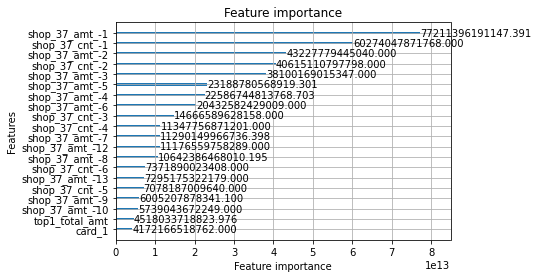

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.04624e+07	valid_1's l2: 1.04301e+07
[100]	training's l2: 1.00287e+07	valid_1's l2: 1.00716e+07
[150]	training's l2: 9.78568e+06	valid_1's l2: 9.89692e+06
[200]	training's l2: 9.63048e+06	valid_1's l2: 9.80428e+06
[250]	training's l2: 9.52373e+06	valid_1's l2: 9.75282e+06
[300]	training's l2: 9.44567e+06	valid_1's l2: 9.72274e+06
[350]	training's l2: 9.38329e+06	valid_1's l2: 9.70416e+06
[400]	training's l2: 9.33262e+06	valid_1's l2: 9.69108e+06
[450]	training's l2: 9.29002e+06	valid_1's l2: 9.68314e+06
[500]	training's l2: 9.25202e+06	valid_1's l2: 9.67735e+06
[550]	training's l2: 9.21888e+06	valid_1's l2: 9.67321e+06
[600]	training's l2: 9.18616e+06	valid_1's l2: 9.67015e+06
[650]	training's l2: 9.1572e+06	valid_1's l2: 9.66862e+06
[700]	training's l2: 9.13259e+06	valid_1's l2: 9.6677e+06
[750]	training's l2: 9.10648e+06	valid_1's l2: 9.66606e+06
[800]	training's l2: 9.08266e+06	valid_1's l2: 9.66555e+

<Figure size 864x432 with 0 Axes>

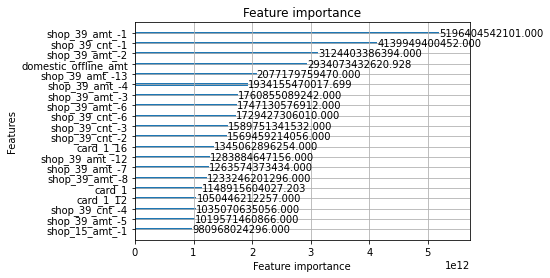

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.14393e+06	valid_1's l2: 9.22147e+06
[100]	training's l2: 7.70072e+06	valid_1's l2: 7.80359e+06
[150]	training's l2: 7.06835e+06	valid_1's l2: 7.20988e+06
[200]	training's l2: 6.72852e+06	valid_1's l2: 6.91102e+06
[250]	training's l2: 6.54797e+06	valid_1's l2: 6.7718e+06
[300]	training's l2: 6.43948e+06	valid_1's l2: 6.70358e+06
[350]	training's l2: 6.36002e+06	valid_1's l2: 6.66282e+06
[400]	training's l2: 6.29911e+06	valid_1's l2: 6.63792e+06
[450]	training's l2: 6.25025e+06	valid_1's l2: 6.62235e+06
[500]	training's l2: 6.20741e+06	valid_1's l2: 6.61025e+06
[550]	training's l2: 6.17177e+06	valid_1's l2: 6.6027e+06
[600]	training's l2: 6.13838e+06	valid_1's l2: 6.5966e+06
[650]	training's l2: 6.10761e+06	valid_1's l2: 6.59178e+06
[700]	training's l2: 6.08156e+06	valid_1's l2: 6.5878e+06
[750]	training's l2: 6.05593e+06	valid_1's l2: 6.58413e+06
[800]	training's l2: 6.03269e+06	valid_1's l2: 6.58119e+06

<Figure size 864x432 with 0 Axes>

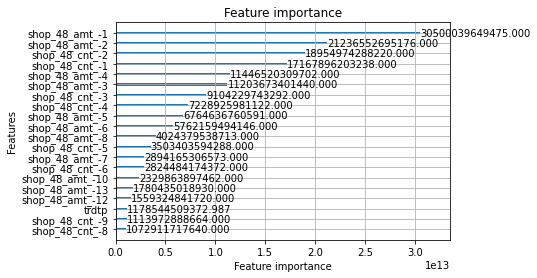

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.01493e+07	valid_1's l2: 2.9854e+07
[100]	training's l2: 2.72625e+07	valid_1's l2: 2.7233e+07
[150]	training's l2: 2.58451e+07	valid_1's l2: 2.60527e+07
[200]	training's l2: 2.50901e+07	valid_1's l2: 2.55095e+07
[250]	training's l2: 2.46446e+07	valid_1's l2: 2.52545e+07
[300]	training's l2: 2.4352e+07	valid_1's l2: 2.51283e+07
[350]	training's l2: 2.41324e+07	valid_1's l2: 2.50612e+07
[400]	training's l2: 2.3965e+07	valid_1's l2: 2.50226e+07
[450]	training's l2: 2.38292e+07	valid_1's l2: 2.49985e+07
[500]	training's l2: 2.37085e+07	valid_1's l2: 2.49819e+07
[550]	training's l2: 2.36096e+07	valid_1's l2: 2.49705e+07
[600]	training's l2: 2.35259e+07	valid_1's l2: 2.49639e+07
[650]	training's l2: 2.34467e+07	valid_1's l2: 2.4958e+07
[700]	training's l2: 2.33717e+07	valid_1's l2: 2.49542e+07
[750]	training's l2: 2.33114e+07	valid_1's l2: 2.49523e+07
[800]	training's l2: 2.32529e+07	valid_1's 

<Figure size 864x432 with 0 Axes>

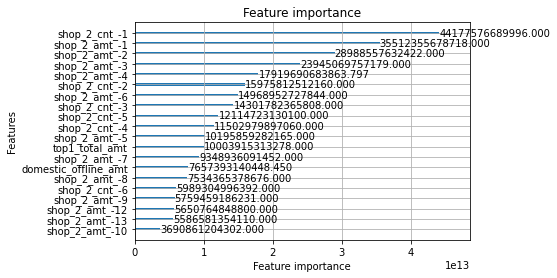

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.0078e+06	valid_1's l2: 7.03597e+06
[100]	training's l2: 6.31925e+06	valid_1's l2: 6.41703e+06
[150]	training's l2: 5.99678e+06	valid_1's l2: 6.14717e+06
[200]	training's l2: 5.82567e+06	valid_1's l2: 6.01839e+06
[250]	training's l2: 5.72988e+06	valid_1's l2: 5.9587e+06
[300]	training's l2: 5.66887e+06	valid_1's l2: 5.92956e+06
[350]	training's l2: 5.62322e+06	valid_1's l2: 5.91244e+06
[400]	training's l2: 5.58806e+06	valid_1's l2: 5.90327e+06
[450]	training's l2: 5.5596e+06	valid_1's l2: 5.89708e+06
[500]	training's l2: 5.53474e+06	valid_1's l2: 5.89259e+06
[550]	training's l2: 5.51459e+06	valid_1's l2: 5.8896e+06
[600]	training's l2: 5.49534e+06	valid_1's l2: 5.88699e+06
[650]	training's l2: 5.47678e+06	valid_1's l2: 5.8851e+06
[700]	training's l2: 5.46072e+06	valid_1's l2: 5.88365e+06
[750]	training's l2: 5.4468e+06	valid_1's l2: 5.88247e+06
[800]	training's l2: 5.43325e+06	valid_1's l2: 5.88152e+06
[

<Figure size 864x432 with 0 Axes>

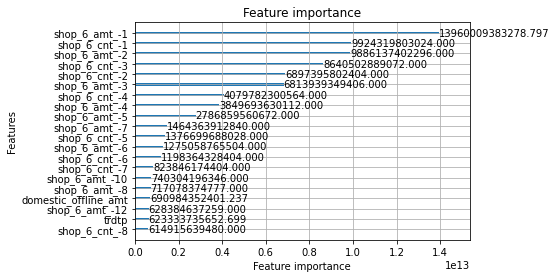

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.37493e+07	valid_1's l2: 2.37902e+07
[100]	training's l2: 2.07204e+07	valid_1's l2: 2.09146e+07
[150]	training's l2: 1.93125e+07	valid_1's l2: 1.96451e+07
[200]	training's l2: 1.85637e+07	valid_1's l2: 1.90265e+07
[250]	training's l2: 1.81363e+07	valid_1's l2: 1.87225e+07
[300]	training's l2: 1.78504e+07	valid_1's l2: 1.85519e+07
[350]	training's l2: 1.76426e+07	valid_1's l2: 1.84536e+07
[400]	training's l2: 1.74711e+07	valid_1's l2: 1.83873e+07
[450]	training's l2: 1.73268e+07	valid_1's l2: 1.83396e+07
[500]	training's l2: 1.71957e+07	valid_1's l2: 1.83009e+07
[550]	training's l2: 1.70863e+07	valid_1's l2: 1.82751e+07
[600]	training's l2: 1.6984e+07	valid_1's l2: 1.82533e+07
[650]	training's l2: 1.68951e+07	valid_1's l2: 1.82341e+07
[700]	training's l2: 1.6809e+07	valid_1's l2: 1.82188e+07
[750]	training's l2: 1.67321e+07	valid_1's l2: 1.82065e+07
[800]	training's l2: 1.66541e+07	valid_1's l2: 1.81962e+

<Figure size 864x432 with 0 Axes>

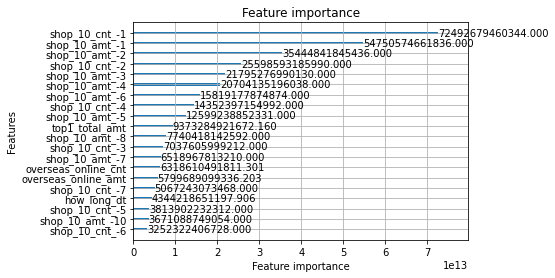

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.66193e+06	valid_1's l2: 9.47553e+06
[100]	training's l2: 8.8664e+06	valid_1's l2: 8.72785e+06
[150]	training's l2: 8.47766e+06	valid_1's l2: 8.38372e+06
[200]	training's l2: 8.27479e+06	valid_1's l2: 8.22343e+06
[250]	training's l2: 8.15593e+06	valid_1's l2: 8.14603e+06
[300]	training's l2: 8.07713e+06	valid_1's l2: 8.10539e+06
[350]	training's l2: 8.01635e+06	valid_1's l2: 8.08197e+06
[400]	training's l2: 7.96639e+06	valid_1's l2: 8.06738e+06
[450]	training's l2: 7.92387e+06	valid_1's l2: 8.05667e+06
[500]	training's l2: 7.88586e+06	valid_1's l2: 8.04938e+06
[550]	training's l2: 7.85174e+06	valid_1's l2: 8.04328e+06
[600]	training's l2: 7.82332e+06	valid_1's l2: 8.03993e+06
[650]	training's l2: 7.79745e+06	valid_1's l2: 8.03688e+06
[700]	training's l2: 7.77317e+06	valid_1's l2: 8.03441e+06
[750]	training's l2: 7.7513e+06	valid_1's l2: 8.03297e+06
[800]	training's l2: 7.7307e+06	valid_1's l2: 8.03161e+0

<Figure size 864x432 with 0 Axes>

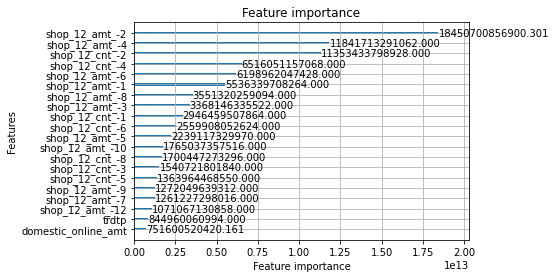

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.46131e+06	valid_1's l2: 3.44686e+06
[100]	training's l2: 2.73376e+06	valid_1's l2: 2.75211e+06
[150]	training's l2: 2.41887e+06	valid_1's l2: 2.46168e+06
[200]	training's l2: 2.24725e+06	valid_1's l2: 2.31085e+06
[250]	training's l2: 2.14667e+06	valid_1's l2: 2.22756e+06
[300]	training's l2: 2.07648e+06	valid_1's l2: 2.1723e+06
[350]	training's l2: 2.02713e+06	valid_1's l2: 2.13679e+06
[400]	training's l2: 1.99007e+06	valid_1's l2: 2.11268e+06
[450]	training's l2: 1.95783e+06	valid_1's l2: 2.09296e+06
[500]	training's l2: 1.93304e+06	valid_1's l2: 2.07965e+06
[550]	training's l2: 1.90769e+06	valid_1's l2: 2.06517e+06
[600]	training's l2: 1.888e+06	valid_1's l2: 2.05587e+06
[650]	training's l2: 1.87012e+06	valid_1's l2: 2.04793e+06
[700]	training's l2: 1.85321e+06	valid_1's l2: 2.04023e+06
[750]	training's l2: 1.8389e+06	valid_1's l2: 2.03543e+06
[800]	training's l2: 1.8248e+06	valid_1's l2: 2.03073e+06


<Figure size 864x432 with 0 Axes>

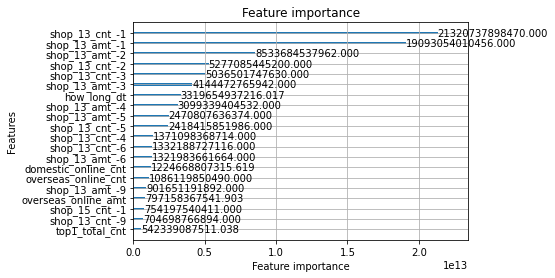

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.82346e+07	valid_1's l2: 1.80991e+07
[100]	training's l2: 1.57722e+07	valid_1's l2: 1.57473e+07
[150]	training's l2: 1.46274e+07	valid_1's l2: 1.47098e+07
[200]	training's l2: 1.40492e+07	valid_1's l2: 1.42334e+07
[250]	training's l2: 1.37281e+07	valid_1's l2: 1.40074e+07
[300]	training's l2: 1.35209e+07	valid_1's l2: 1.38915e+07
[350]	training's l2: 1.33687e+07	valid_1's l2: 1.38209e+07
[400]	training's l2: 1.32513e+07	valid_1's l2: 1.37786e+07
[450]	training's l2: 1.31528e+07	valid_1's l2: 1.37503e+07
[500]	training's l2: 1.30702e+07	valid_1's l2: 1.3729e+07
[550]	training's l2: 1.3003e+07	valid_1's l2: 1.37145e+07
[600]	training's l2: 1.29449e+07	valid_1's l2: 1.37032e+07
[650]	training's l2: 1.2889e+07	valid_1's l2: 1.36943e+07
[700]	training's l2: 1.28365e+07	valid_1's l2: 1.36879e+07
[750]	training's l2: 1.27879e+07	valid_1's l2: 1.3682e+07
[800]	training's l2: 1.27391e+07	valid_1's l2: 1.36776e+07

<Figure size 864x432 with 0 Axes>

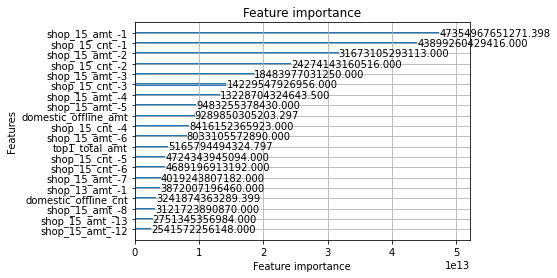

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.91785e+06	valid_1's l2: 7.81252e+06
[100]	training's l2: 7.49534e+06	valid_1's l2: 7.44577e+06
[150]	training's l2: 7.26927e+06	valid_1's l2: 7.269e+06
[200]	training's l2: 7.12915e+06	valid_1's l2: 7.17577e+06
[250]	training's l2: 7.03805e+06	valid_1's l2: 7.126e+06
[300]	training's l2: 6.97248e+06	valid_1's l2: 7.0988e+06
[350]	training's l2: 6.92134e+06	valid_1's l2: 7.08186e+06
[400]	training's l2: 6.87903e+06	valid_1's l2: 7.07116e+06
[450]	training's l2: 6.84469e+06	valid_1's l2: 7.06468e+06
[500]	training's l2: 6.81576e+06	valid_1's l2: 7.06038e+06
[550]	training's l2: 6.78906e+06	valid_1's l2: 7.05732e+06
[600]	training's l2: 6.76575e+06	valid_1's l2: 7.05558e+06
[650]	training's l2: 6.74177e+06	valid_1's l2: 7.05403e+06
[700]	training's l2: 6.72142e+06	valid_1's l2: 7.05346e+06
[750]	training's l2: 6.70265e+06	valid_1's l2: 7.05278e+06
[800]	training's l2: 6.68475e+06	valid_1's l2: 7.05245e+06


<Figure size 864x432 with 0 Axes>

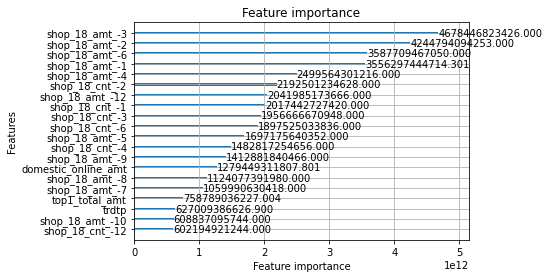

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.42283e+07	valid_1's l2: 1.45745e+07
[100]	training's l2: 1.34687e+07	valid_1's l2: 1.38972e+07
[150]	training's l2: 1.30455e+07	valid_1's l2: 1.35538e+07
[200]	training's l2: 1.27919e+07	valid_1's l2: 1.33789e+07
[250]	training's l2: 1.26234e+07	valid_1's l2: 1.32856e+07
[300]	training's l2: 1.24985e+07	valid_1's l2: 1.32318e+07
[350]	training's l2: 1.23999e+07	valid_1's l2: 1.31991e+07
[400]	training's l2: 1.23148e+07	valid_1's l2: 1.31747e+07
[450]	training's l2: 1.22442e+07	valid_1's l2: 1.31578e+07
[500]	training's l2: 1.21808e+07	valid_1's l2: 1.31461e+07
[550]	training's l2: 1.21277e+07	valid_1's l2: 1.31375e+07
[600]	training's l2: 1.20837e+07	valid_1's l2: 1.31308e+07
[650]	training's l2: 1.20409e+07	valid_1's l2: 1.31257e+07
[700]	training's l2: 1.20035e+07	valid_1's l2: 1.31225e+07
[750]	training's l2: 1.19666e+07	valid_1's l2: 1.31197e+07
[800]	training's l2: 1.19319e+07	valid_1's l2: 1.31173

<Figure size 864x432 with 0 Axes>

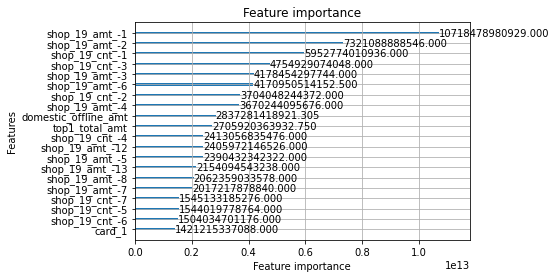

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.50577e+06	valid_1's l2: 8.47075e+06
[100]	training's l2: 8.23502e+06	valid_1's l2: 8.25797e+06
[150]	training's l2: 8.07864e+06	valid_1's l2: 8.15598e+06
[200]	training's l2: 7.97309e+06	valid_1's l2: 8.10005e+06
[250]	training's l2: 7.89515e+06	valid_1's l2: 8.06836e+06
[300]	training's l2: 7.83639e+06	valid_1's l2: 8.05041e+06
[350]	training's l2: 7.78786e+06	valid_1's l2: 8.03915e+06
[400]	training's l2: 7.74683e+06	valid_1's l2: 8.0324e+06
[450]	training's l2: 7.71301e+06	valid_1's l2: 8.0276e+06
[500]	training's l2: 7.68327e+06	valid_1's l2: 8.02448e+06
[550]	training's l2: 7.65542e+06	valid_1's l2: 8.02163e+06
[600]	training's l2: 7.63152e+06	valid_1's l2: 8.02024e+06
[650]	training's l2: 7.608e+06	valid_1's l2: 8.01943e+06
[700]	training's l2: 7.58694e+06	valid_1's l2: 8.01896e+06
[750]	training's l2: 7.5668e+06	valid_1's l2: 8.01871e+06
[800]	training's l2: 7.54673e+06	valid_1's l2: 8.01867e+06


<Figure size 864x432 with 0 Axes>

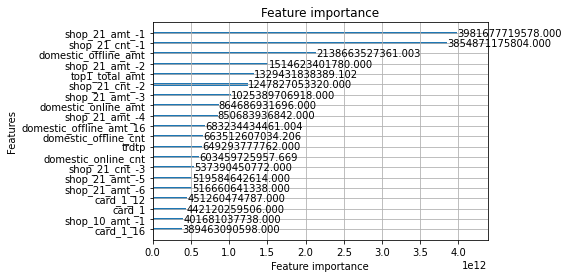

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.58449e+06	valid_1's l2: 2.58454e+06
[100]	training's l2: 2.38472e+06	valid_1's l2: 2.39971e+06
[150]	training's l2: 2.2804e+06	valid_1's l2: 2.31021e+06
[200]	training's l2: 2.2229e+06	valid_1's l2: 2.26708e+06
[250]	training's l2: 2.1867e+06	valid_1's l2: 2.24428e+06
[300]	training's l2: 2.16303e+06	valid_1's l2: 2.23278e+06
[350]	training's l2: 2.14542e+06	valid_1's l2: 2.22662e+06
[400]	training's l2: 2.13182e+06	valid_1's l2: 2.22305e+06
[450]	training's l2: 2.11971e+06	valid_1's l2: 2.22058e+06
[500]	training's l2: 2.10968e+06	valid_1's l2: 2.21883e+06
[550]	training's l2: 2.10116e+06	valid_1's l2: 2.21776e+06
[600]	training's l2: 2.09352e+06	valid_1's l2: 2.21702e+06
[650]	training's l2: 2.08668e+06	valid_1's l2: 2.21637e+06
[700]	training's l2: 2.0811e+06	valid_1's l2: 2.21604e+06
[750]	training's l2: 2.07543e+06	valid_1's l2: 2.21595e+06
[800]	training's l2: 2.06957e+06	valid_1's l2: 2.21585e+06

<Figure size 864x432 with 0 Axes>

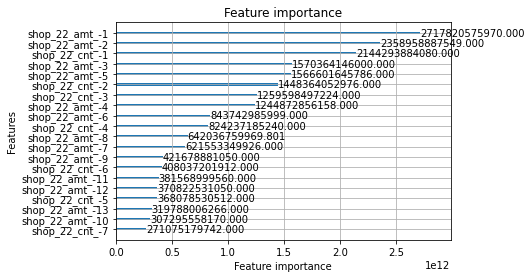

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.08142e+06	valid_1's l2: 4.23574e+06
[100]	training's l2: 3.78482e+06	valid_1's l2: 3.95003e+06
[150]	training's l2: 3.63123e+06	valid_1's l2: 3.81181e+06
[200]	training's l2: 3.54353e+06	valid_1's l2: 3.74112e+06
[250]	training's l2: 3.48943e+06	valid_1's l2: 3.70518e+06
[300]	training's l2: 3.45103e+06	valid_1's l2: 3.68546e+06
[350]	training's l2: 3.4219e+06	valid_1's l2: 3.67383e+06
[400]	training's l2: 3.3997e+06	valid_1's l2: 3.66641e+06
[450]	training's l2: 3.38008e+06	valid_1's l2: 3.66138e+06
[500]	training's l2: 3.36461e+06	valid_1's l2: 3.65802e+06
[550]	training's l2: 3.35102e+06	valid_1's l2: 3.65579e+06
[600]	training's l2: 3.33929e+06	valid_1's l2: 3.65419e+06
[650]	training's l2: 3.32837e+06	valid_1's l2: 3.65314e+06
[700]	training's l2: 3.31832e+06	valid_1's l2: 3.65229e+06
[750]	training's l2: 3.30856e+06	valid_1's l2: 3.65155e+06
[800]	training's l2: 3.29952e+06	valid_1's l2: 3.6511e+0

<Figure size 864x432 with 0 Axes>

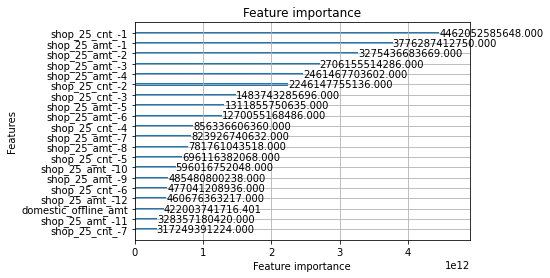

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.16403e+07	valid_1's l2: 1.13569e+07
[100]	training's l2: 1.12197e+07	valid_1's l2: 1.10101e+07
[150]	training's l2: 1.09902e+07	valid_1's l2: 1.08491e+07
[200]	training's l2: 1.08492e+07	valid_1's l2: 1.07714e+07
[250]	training's l2: 1.07499e+07	valid_1's l2: 1.07273e+07
[300]	training's l2: 1.06747e+07	valid_1's l2: 1.07016e+07
[350]	training's l2: 1.06137e+07	valid_1's l2: 1.06859e+07
[400]	training's l2: 1.05674e+07	valid_1's l2: 1.0679e+07
[450]	training's l2: 1.05249e+07	valid_1's l2: 1.06731e+07
[500]	training's l2: 1.04867e+07	valid_1's l2: 1.06696e+07
[550]	training's l2: 1.04516e+07	valid_1's l2: 1.06679e+07
[600]	training's l2: 1.04184e+07	valid_1's l2: 1.06663e+07
[650]	training's l2: 1.03902e+07	valid_1's l2: 1.06651e+07
[700]	training's l2: 1.03645e+07	valid_1's l2: 1.06651e+07
[750]	training's l2: 1.03406e+07	valid_1's l2: 1.06645e+07
[800]	training's l2: 1.03155e+07	valid_1's l2: 1.06649e

<Figure size 864x432 with 0 Axes>

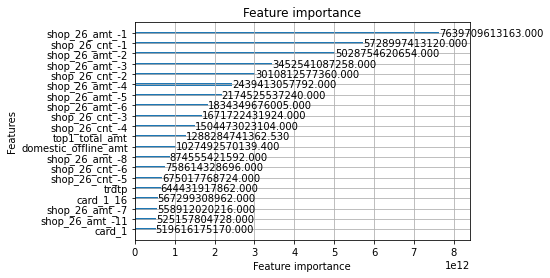

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.28319e+06	valid_1's l2: 8.30811e+06
[100]	training's l2: 6.41311e+06	valid_1's l2: 6.47174e+06
[150]	training's l2: 5.56498e+06	valid_1's l2: 5.65553e+06
[200]	training's l2: 5.15655e+06	valid_1's l2: 5.27849e+06
[250]	training's l2: 4.95598e+06	valid_1's l2: 5.10944e+06
[300]	training's l2: 4.84636e+06	valid_1's l2: 5.03106e+06
[350]	training's l2: 4.76724e+06	valid_1's l2: 4.9816e+06
[400]	training's l2: 4.70985e+06	valid_1's l2: 4.95342e+06
[450]	training's l2: 4.66264e+06	valid_1's l2: 4.93303e+06
[500]	training's l2: 4.62504e+06	valid_1's l2: 4.92051e+06
[550]	training's l2: 4.59178e+06	valid_1's l2: 4.9106e+06
[600]	training's l2: 4.56215e+06	valid_1's l2: 4.90307e+06
[650]	training's l2: 4.53729e+06	valid_1's l2: 4.89784e+06
[700]	training's l2: 4.51455e+06	valid_1's l2: 4.89415e+06
[750]	training's l2: 4.49474e+06	valid_1's l2: 4.89149e+06
[800]	training's l2: 4.4751e+06	valid_1's l2: 4.88836e+0

<Figure size 864x432 with 0 Axes>

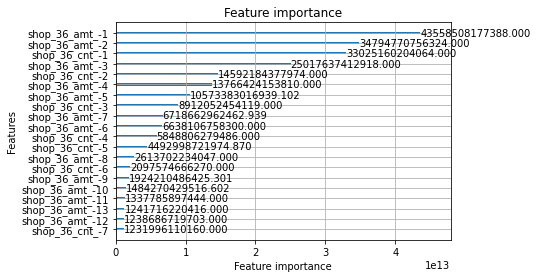

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.44731e+07	valid_1's l2: 2.47294e+07
[100]	training's l2: 2.0469e+07	valid_1's l2: 2.08667e+07
[150]	training's l2: 1.87222e+07	valid_1's l2: 1.92457e+07
[200]	training's l2: 1.78915e+07	valid_1's l2: 1.85336e+07
[250]	training's l2: 1.74498e+07	valid_1's l2: 1.82062e+07
[300]	training's l2: 1.71756e+07	valid_1's l2: 1.80405e+07
[350]	training's l2: 1.69843e+07	valid_1's l2: 1.79494e+07
[400]	training's l2: 1.68373e+07	valid_1's l2: 1.7893e+07
[450]	training's l2: 1.67139e+07	valid_1's l2: 1.78553e+07
[500]	training's l2: 1.66099e+07	valid_1's l2: 1.78269e+07
[550]	training's l2: 1.65246e+07	valid_1's l2: 1.78084e+07
[600]	training's l2: 1.64415e+07	valid_1's l2: 1.77919e+07
[650]	training's l2: 1.63726e+07	valid_1's l2: 1.77805e+07
[700]	training's l2: 1.63044e+07	valid_1's l2: 1.77711e+07
[750]	training's l2: 1.62502e+07	valid_1's l2: 1.77644e+07
[800]	training's l2: 1.61913e+07	valid_1's l2: 1.77578e+

<Figure size 864x432 with 0 Axes>

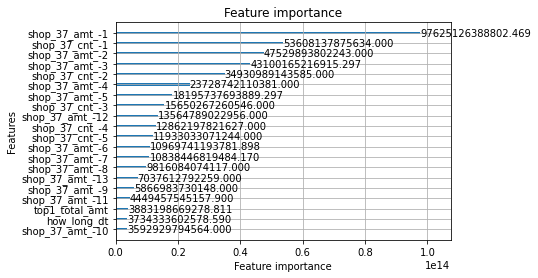

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.04493e+07	valid_1's l2: 1.05159e+07
[100]	training's l2: 1.00261e+07	valid_1's l2: 1.01504e+07
[150]	training's l2: 9.77971e+06	valid_1's l2: 9.95969e+06
[200]	training's l2: 9.6249e+06	valid_1's l2: 9.85887e+06
[250]	training's l2: 9.51591e+06	valid_1's l2: 9.79996e+06
[300]	training's l2: 9.43647e+06	valid_1's l2: 9.7653e+06
[350]	training's l2: 9.37256e+06	valid_1's l2: 9.74343e+06
[400]	training's l2: 9.31998e+06	valid_1's l2: 9.7283e+06
[450]	training's l2: 9.27668e+06	valid_1's l2: 9.71897e+06
[500]	training's l2: 9.2346e+06	valid_1's l2: 9.71003e+06
[550]	training's l2: 9.20197e+06	valid_1's l2: 9.70497e+06
[600]	training's l2: 9.17149e+06	valid_1's l2: 9.70037e+06
[650]	training's l2: 9.14293e+06	valid_1's l2: 9.69644e+06
[700]	training's l2: 9.11505e+06	valid_1's l2: 9.69391e+06
[750]	training's l2: 9.08948e+06	valid_1's l2: 9.69138e+06
[800]	training's l2: 9.06751e+06	valid_1's l2: 9.68949e+06

<Figure size 864x432 with 0 Axes>

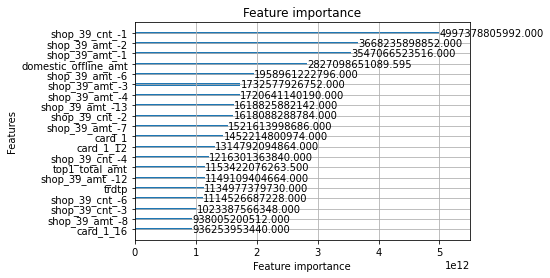

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.09979e+06	valid_1's l2: 9.13767e+06
[100]	training's l2: 7.65377e+06	valid_1's l2: 7.74546e+06
[150]	training's l2: 7.00341e+06	valid_1's l2: 7.14251e+06
[200]	training's l2: 6.69288e+06	valid_1's l2: 6.87662e+06
[250]	training's l2: 6.52277e+06	valid_1's l2: 6.74897e+06
[300]	training's l2: 6.42083e+06	valid_1's l2: 6.6877e+06
[350]	training's l2: 6.34882e+06	valid_1's l2: 6.6545e+06
[400]	training's l2: 6.29114e+06	valid_1's l2: 6.63258e+06
[450]	training's l2: 6.24187e+06	valid_1's l2: 6.61714e+06
[500]	training's l2: 6.20011e+06	valid_1's l2: 6.60732e+06
[550]	training's l2: 6.16467e+06	valid_1's l2: 6.60044e+06
[600]	training's l2: 6.13153e+06	valid_1's l2: 6.59428e+06
[650]	training's l2: 6.10188e+06	valid_1's l2: 6.58976e+06
[700]	training's l2: 6.07415e+06	valid_1's l2: 6.58606e+06
[750]	training's l2: 6.0481e+06	valid_1's l2: 6.5832e+06
[800]	training's l2: 6.02248e+06	valid_1's l2: 6.58094e+06

<Figure size 864x432 with 0 Axes>

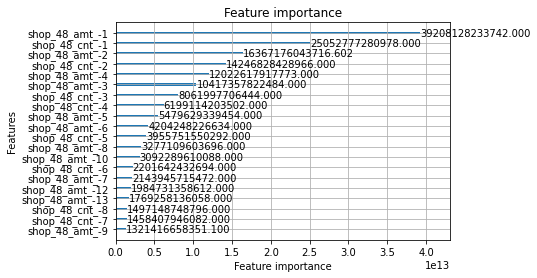

In [22]:
results = {a_cate: [] for a_cate in cnt_handler.ylabels}
train_results = {a_cate: [] for a_cate in cnt_handler.ylabels}

for fold, (trn_ind, val_ind) in enumerate(idx_results):
    print(f'Training fold {fold + 1}')
    for ylabel in cnt_handler.ylabels:
        col_name = ylabel

        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(amt_test))
        results[ylabel].append(result)

In [23]:
loader.save_data([results, train_results, idx_results],
                 '2021_12_20_amt_cnt_train_results.joblib',
                 '2021_12_20 rerun generate_train_results')
